This code builds Latent Dirichlet Allocation (LDA) model from a users given tweet data. To run, be sure to load each cell, and then run the cell that contains the call to the lda_analysis and nmf_analysis functions. The matplotlib plots will be automatically generated. If you want to generate an interactive plotly plot, load and run the next set of cells after you have run the cells that build the models.  

Ultimately, this script will generate a time series showing the users change in topics.

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation 
from collections import Counter

In [4]:
class topic_model():
    """
    Class for LDA topic model
    """
    
    def __init__(self, dataframe, n_topics):
        """
        Initiate the model
        """
        self.n_topics = n_topics
        self.data = dataframe

    def lda_analysis(self):
        """ 
        Vectorize tweet data and run LDA. If optimize = True, grid search will run and report perplexity 
        of the model as the number of topics changes.
        LDA can only use raw term counts for LDA because it is a probabilistic graphical model
        """

        n_features = 1000 

        tf_vectorizer = CountVectorizer(max_df = 0.95, min_df = 2, max_features = n_features, stop_words='english')
        tf = tf_vectorizer.fit_transform(self.data['filtered_text'])
        tf_feature_names = tf_vectorizer.get_feature_names()

        lda = LatentDirichletAllocation(n_components = self.n_topics, learning_method = 'online', random_state=0).fit(tf)
        lda_transform = lda.transform(tf)
        error = lda.perplexity(tf)
        print("Model's perplexity:", error)
        print("Model's score':" , lda.score(tf))
        
        lda_keys = []
        for i in range(lda_transform.shape[0]):
            lda_keys.append(lda_transform[i].argmax()) # Change to string so label types can be consistent for plotting
        
        self.data['labels'] = pd.Series(lda_keys, index = self.data.index)

        return(lda, lda_transform, tf_feature_names)
            
    def drop_tweets(self, probabilities):
        """
        Remove all tweets that have a low probability of being in all topics
        """

        probabilities_df = pd.DataFrame(probabilities).copy()
        probabilities_df.where(probabilities_df >.8, inplace = True)
        probabilities_df.dropna(how='all', inplace = True)
        self.data = self.data.loc[probabilities_df.index].copy()
        
    def run_tsne(self, transform):
        """
        Run tsne
        """
        print("Dimensionality reduction...")
        tsne = TSNE(n_components = 2, perplexity = 50, random_state = 0, init = 'pca').fit_transform(transform)
        self.data['x'] = pd.Series(tsne[:, 0], index = self.data.index)
        self.data['y'] = pd.Series(tsne[:, 1], index = self.data.index)
        print("Done")

    def display_topics(self, model, feature_names):
        """
        Display the most frequent words per topic in bar graph format.
        Returns the words that define each topic.
        """
        
        n_top_words = 5
        topics = []

        fig = plt.figure(figsize = (30, 20))

        for topic_n, topic in enumerate(model.components_): # topic_n is the index: 1,2,3...
            frequency = list(topic.argsort()[:-n_top_words - 1:-1])
            topic_list = [feature_names[i] for i in frequency]
            
            topic_string = ",".join(topic_list)

            topics.append(topic_string)
            ax = fig.add_subplot(4, 5, topic_n+1)
            index = np.arange(len(frequency))
            width = .9
            ax.barh(index, frequency, width, align = 'center')
            ax.set_yticks(index)
            font = {'fontsize': 17}
            ax.set_yticklabels(topic_list, fontdict = font)
            ax.tick_params(labelsize = 17)
            ax.set_title('Topic {}'.format(topic_n), fontsize = 17)
            
        plt.tight_layout()
        plt.show()
        fig.savefig(
            '/home/timor/Documents/Git/Twitter-Mining/trump/data/word_frequencies_topic_{}.png'.format(topic_n))
        plt.close()

        return topics
    
    def tweets_per_topic(self):
        """
        Plot the number of tweets per topic for a given week/model
        """
        
        tweets_per_topic = []
        
        for i in range(self.n_topics):
            df = self.data.loc[self.data['labels'] == i]
            tweets_per_topic.append(df.shape[0])
        
        return(tweets_per_topic)

    def word_frequencies(self, word):
        """
        Get the most frequent words (like per week)
        """
        
        count_words = Counter()
        count_words.update(" ".join(self.data['filtered_text'].values.tolist()).split(" "))
   
        freq = count_words.get(word, 0)
        
        print("word: {0}, frequency: {1}".format(word, freq))
                
        return freq
        
    def get_data(self):
        """
        Return the dataframe
        """
        return self.data
    
    def save_dataframe(self):
        """
        Save the data. Nice to save if I've added labels and tsne data
        """
        
        self.data.to_csv("~/Documents/Git/Twitter-Mining/trump/data/topic_labels_sentiment_converted_tweets.tsv", sep = '\t', index = False)


class topic_series():
    """
    Class for building topic time series
    """
    
    def __init__(self):
        """
        Initiate instance of topic time series
        """
        
        self.topic_series_df = pd.DataFrame()
        
    def topic_change(self, week, topics, n_tweets):
        """
        Add topics and number of tweets for each topic to dataframe
        """
      
        self.topic_series_df['topics_{}'.format(week)] = topics
        self.topic_series_df['n_tweets_{}'.format(week)] = n_tweets
        
    def save_dataframe(self):
        
        self.topic_series_df.to_csv('/home/timor/Documents/Git/Twitter-Mining/trump/data/topic_time_series.tsv', sep = '\t', index = False)
        
    def print_dataframe(self):
        
        print(self.topic_series_df)

Create a lda model for each week. The script iterates through all tweets with a certain week label and generates the lda. The problem with this is that it is a silly way to do it and instead I should just run lda for the whole set, add the labels, and then in the time series script each label in a time series. One good thing about it though is that it does calculate the word usage per week. Though a contribed way to do it, I don't mind.

In [3]:
tweet_dataframe = pd.read_csv(
      "~/Documents/Git/Twitter-Mining/trump/data/sentiment_converted_tweets.tsv", sep = '\t', parse_dates = [1])

In [10]:
tweet_dataframe['week'] = tweet_dataframe['date'].dt.week
n_topics = 11
series = topic_series()
immigration_series = []
china_series = []
gun_series = []
korea_series = []
trade_series = []
russia_series = []
comey_series = []
great_series = []
fake_series = []
wall_series = []
fbi_series = []

for i in range(tweet_dataframe['week'].min(),tweet_dataframe['week'].max() + 1): 
    # Merge 2 weeks
    #week_of_tweets = tweet_dataframe.loc[(tweet_dataframe['week'] == i) | (tweet_dataframe['week'] == i+1), :].copy()
    week_of_tweets = tweet_dataframe.loc[tweet_dataframe['week'] == i, :].copy()
    week_of_tweets.reset_index(drop = True, inplace = True)
    model = topic_model(week_of_tweets, n_topics) 
    # Create the LDA model and generate cluster labels
    #lda, lda_transform, feature_names = model.lda_analysis()
    #topics = model.display_topics(lda, feature_names) 
    #model.run_tsne(lda_transform)
    #model.drop_tweets(lda_transform) # Drop tweets below p cutoff.
    #n_tweets = model.tweets_per_topic()
    #data = model.get_data()
    #visualize_mpl(data, topics) 
    #series.topic_change(i, topics, n_tweets)
    
    immigration_series.append(model.word_frequencies('immigration'))
    china_series.append(model.word_frequencies('china'))
    gun_series.append(model.word_frequencies('guns'))
    korea_series.append(model.word_frequencies('korea'))
    trade_series.append(model.word_frequencies('trade'))
    russia_series.append(model.word_frequencies('russia'))
    wall_series.append(model.word_frequencies('wall'))
    fake_series.append(model.word_frequencies('fake'))
    great_series.append(model.word_frequencies('great'))
    fbi_series.append(model.word_frequencies('fbi'))
    comey_series.append(model.word_frequencies('comey'))

word: immigration, frequency: 0
word: china, frequency: 0
word: guns, frequency: 0
word: korea, frequency: 0
word: trade, frequency: 0
word: russia, frequency: 1
word: wall, frequency: 0
word: fake, frequency: 3
word: great, frequency: 2
word: fbi, frequency: 3
word: comey, frequency: 4
word: immigration, frequency: 0
word: china, frequency: 0
word: guns, frequency: 1
word: korea, frequency: 1
word: trade, frequency: 1
word: russia, frequency: 5
word: wall, frequency: 7
word: fake, frequency: 2
word: great, frequency: 6
word: fbi, frequency: 0
word: comey, frequency: 0
word: immigration, frequency: 1
word: china, frequency: 1
word: guns, frequency: 0
word: korea, frequency: 1
word: trade, frequency: 1
word: russia, frequency: 0
word: wall, frequency: 2
word: fake, frequency: 2
word: great, frequency: 10
word: fbi, frequency: 0
word: comey, frequency: 0
word: immigration, frequency: 4
word: china, frequency: 6
word: guns, frequency: 0
word: korea, frequency: 0
word: trade, frequency: 10

Save word frequency list as dataframe

In [11]:
word_series = pd.DataFrame({'immigration': immigration_series, 
                            'china': china_series, 
                            'guns': gun_series,
                            'korea': korea_series,
                            'trade': trade_series,
                            'russia': russia_series,
                            'wall': wall_series,
                            'fake': fake_series,
                            'great': great_series,
                            'fbi': fbi_series, 
                            'comey': comey_series
                           })

word_series.to_csv('/home/timor/Documents/Git/Twitter-Mining/trump/data/word_frequencies.tsv', sep = '\t')

In [27]:
word_series

,immigration
0,0
1,0
2,1
3,4
4,0
5,0
6,3
7,3
8,0
9,0


Save the dataframe containing topics and tweet frequency per week

In [26]:
series.save_dataframe()

Focus on one week if necessary:

In [23]:
tweet_dataframe['week'] = tweet_dataframe['date'].dt.week
tweet_dataframe = tweet_dataframe.loc[tweet_dataframe['week'] == 18, :].copy()
tweet_dataframe.reset_index(drop = True, inplace = True)

Build topic model for all tweets in dataset.
In the cell below, initate the model, create topics, and plot

Model's perplexity: 1059.22070885
Model's score': -42836.5257288


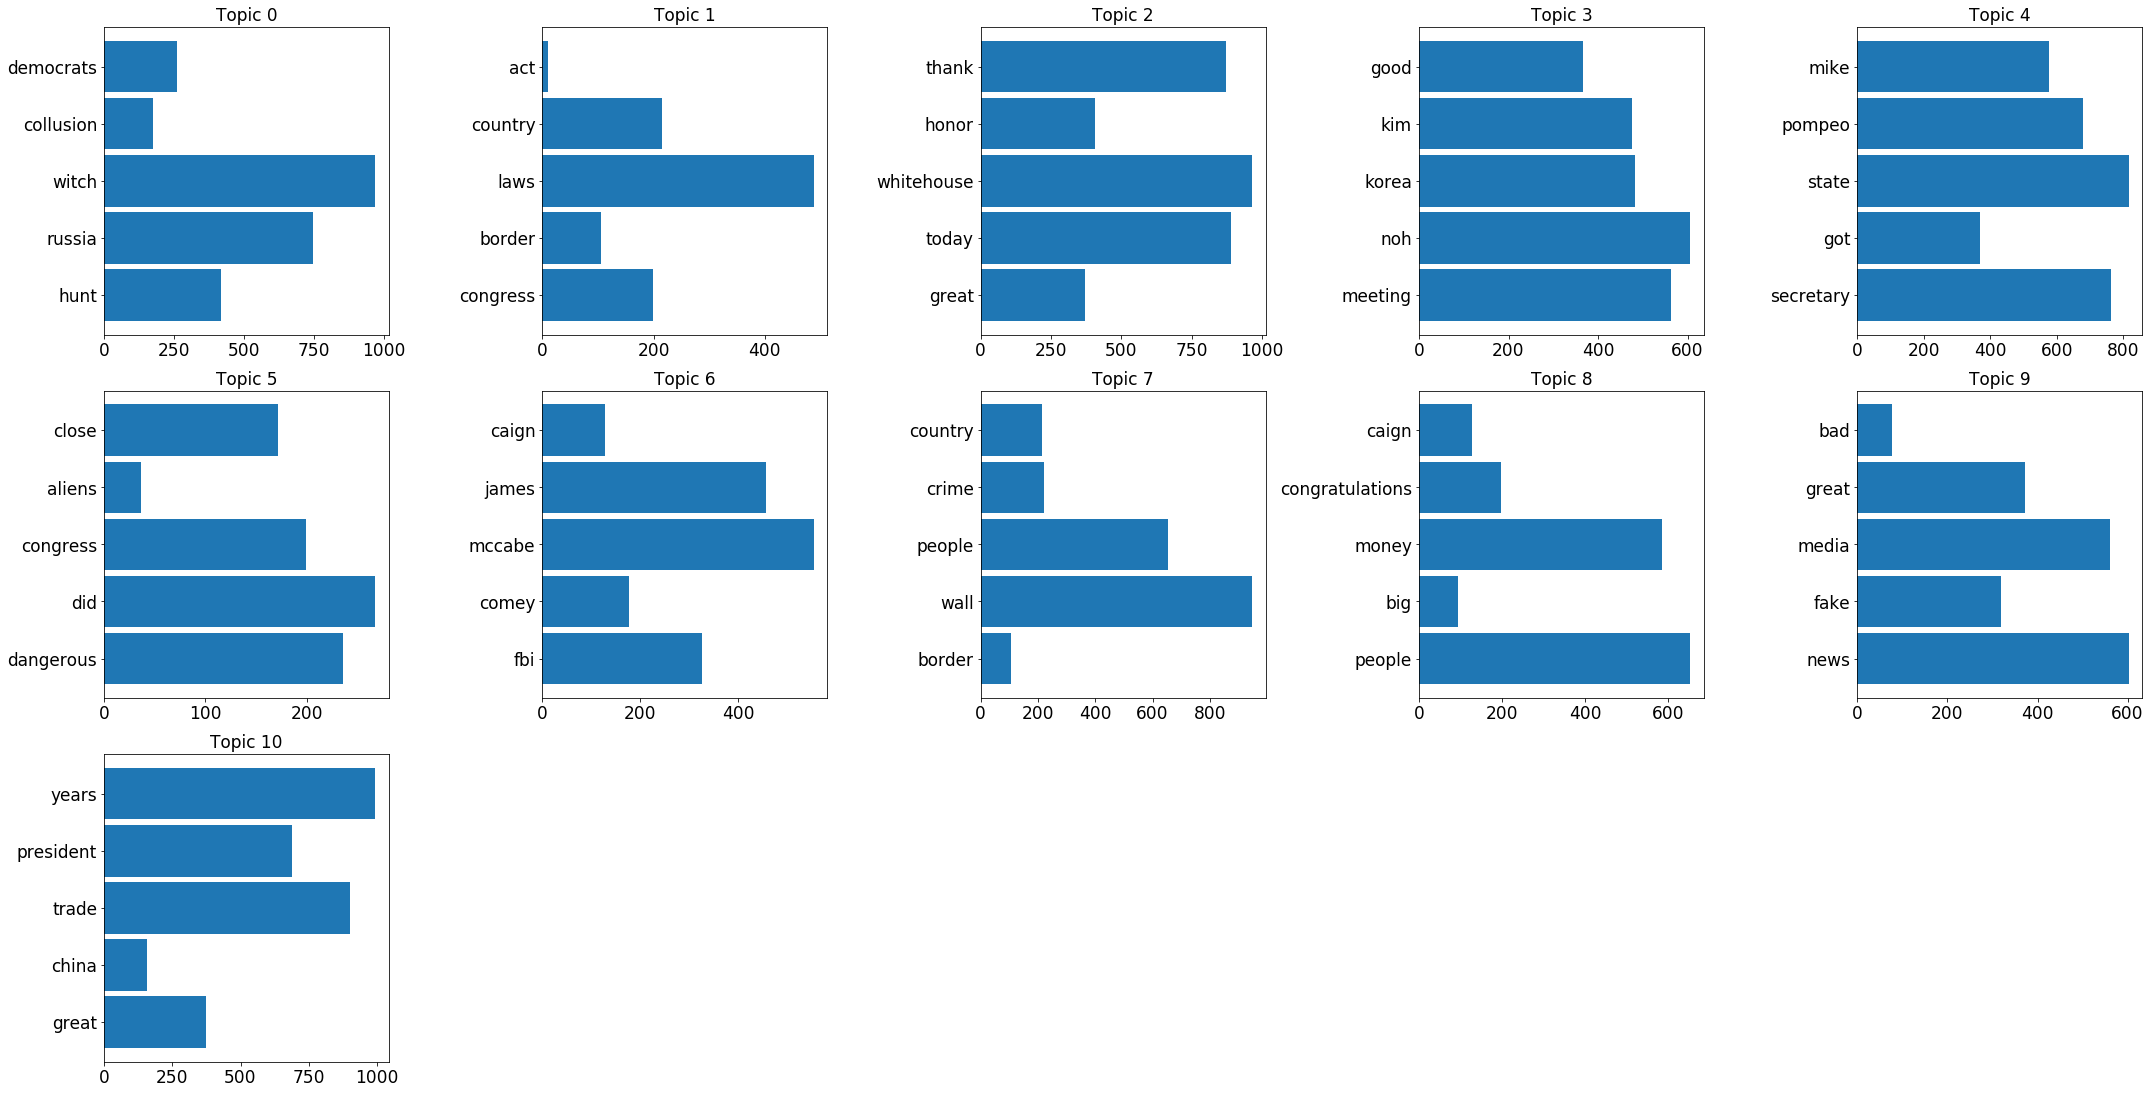

Dimensionality reduction...
Done


NameError: name 'visualize_mpl' is not defined

In [5]:
n_topics = 11
model = topic_model(tweet_dataframe, n_topics)
# Create the LDA model and generate cluster labels
lda, lda_transform, feature_names = model.lda_analysis()
topics = model.display_topics(lda, feature_names)
model.run_tsne(lda_transform) 
#model.drop_tweets(lda_transform)
n_tweets = model.tweets_per_topic()
data = model.get_data()
visualize_mpl(data, topics) 



In [43]:
visualize_plotly(data, topics)

In [16]:
model.save_dataframe()

The cells below contain the function necessary for plotting

In [6]:
def visualize_mpl(dataframe, topics):
    """
    Plot tsne data using matplotlib. When calling this function, no error or method need be
    provided. These arguments are only used by gridsearch.
    """
    
    colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(set(pd.Series(dataframe['labels'])))))
    # https://matplotlib.org/examples/color/colormaps_reference.html

    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_title('{0} topics'.format(len(topics)))
    
    # Thank you!:
    #https://stackoverflow.com/questions/46819664/how-to-add-labels-to-t-sne-in-python
    # https://www.kaggle.com/tilii7/t-sne-visualization/code

    for i, color in zip(range(len(topics)), colors):
        
        ax.scatter(dataframe.loc[dataframe['labels'] == i, 'x'],
                   dataframe.loc[dataframe['labels'] == i, 'y'], 
                   label = topics[i], c = color)
  
    # https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 15)

    plt.show()
    
    fig.savefig('/home/timor/Documents/Git/Twitter-Mining/trump/data/trump_topics.png')
    
    plt.close()

In [41]:
#import plotly.plotly as py
import plotly
#from plotly.offline import plot

In [42]:
def visualize_plotly(dataframe, topics): 
    """
    Visualize tsne data using plotly. The colors and number of topics must be hardcoded.
    """

    # oh wow very annoying problem
    # https://stackoverflow.com/questions/25792086/panda-merge-return-empty-dataframe
    df_palette = pd.DataFrame([
            [0, '#C03028'],
            [1, '#F08030'],
            [2, '#6890F0'],
            [3, '#78C850'],
            [4, '#A890F0'],
            [5, '#A040A0'],
            [6, '#F8D030'],
            [7, '#E0C068'],
            [8, '#F85888'],
            [9, '#B8A038'],
            [10, '#98D8D8']])
            
            #[11, '#A8B820'],])
            #[12, '#7038F8'],
            #[13, '#705898'],
            #[14, '#705848'],
            #[15, '#B8B8D0'],
            #[16, '#A8A878'],
            #[17, '#EE99AC']])
            
    df_palette.columns = ['labels', 'typecolor']
    dataframe.merge(df_palette, on = 'labels')

    plot_list = []
    
    for idx, (label, color) in df_palette.iterrows():
   
        # Select data that corresponds to 1 topic
        df_filter = dataframe[dataframe['labels'] == label]

        # create a scatter object for each topic
        scatter = dict(
            mode = "markers",
            name = "{}".format(topics[label]), # returns label
            type = "scatter",
            text =  df_filter['text'],
            showlegend = True,
            #legendgroup = "stuff", # can use this to group things in the legend I think...
            x =  df_filter['x'], y =  df_filter['y'],
            marker = dict( 
                #size=10, 
                color = color)) 
                #line = dict(
                #width = 3)))
    
        plot_list.append(scatter) 
    
    # need this to override plotly non-iterative settings
    empty_axis = dict(zeroline=False, showaxeslabels=False, showticklabels=False, title='')
    layout = dict(
                scene = dict(
                    xaxis = empty_axis,
                    yaxis = empty_axis,
                    ),
                hovermode = 'closest',
                showlegend = True)

    fig = dict(data = plot_list, layout = layout)
    plotly.offline.plot(fig, filename='topic_model_trump.html')
    #plot_url = py.plot(fig)
